#### Octavio Revetria 232745

# Reinforcement Learning Tarea 1 - K Armed Bandits

## Objetivos
- Demostrar entendimiento sobre K-Armed Bandits
- Implementar varios algoritmos vistos en el curso teórico 
- comparar su performance en un mismo problema (ambiente).

## A entregar
- Implementación de agente arbitrario.
- Implementación de agente epsilon-greedy.
- Implementación de agente epsilon-greedy optimista.
- Implementación de agente upper confidence bound.
- Grafique la evolución de las recompensas (reward) a lo largo del tiempo para cada algoritmo, promediado sobre 2000 ejecuciones.
- Escriba un reporte sobre sus implementaciones comparando los distintos agentes implementados.
- [Extra] Implementación de epsilon-greedy con decay.

## Descripción del ambiente a usar

Vamos a usar KBanditsEnv, un ambiente implementado con [Gymnasium](https://gymnasium.farama.org/index.html) pero orientada a [Armed Bandits](https://en.wikipedia.org/wiki/Multi-armed_bandit). 

Recordando el teórico, sabemos que un K Armed Bandit representa una maquina tragamonedas con multiples brazos (K) y donde nuestra recompensa depende de cual brazo tiremos.

En este caso particular, `k_bandits_env/KBanditsGaussian-v0` es el ambiente a utilizar (página 28 del libro de Sutton y Barto), cuenta con 10 brazos (K=10) y por cada interaccion con el ambiente (`step`) nustra recompensa (reward) depende de que brazo elegimos entre los 10 posibles. En este ambiente, todos los brazos tienen una recompensa (que puede ser negativa en algunos casos) y nuestro objetivo es diseñar agentes que maximicen la suma total de recompensas a lo largo de 1000 interacciones con el ambiente (`1000 steps`).

![KBandits](https://miro.medium.com/v2/resize:fit:720/format:webp/1*iguhq3SaQd730c-TYI8QZA.png)

El valor verdadero ($q_*(a)$) de cada brazo es muestreado de una distribución normal con media 0 y varianza 1. La recompensa de cada brazo es muestreada de una distribución normal con media $q_*(a)$ y varianza 1.


> Nota: El agente no tiene acceso a los valores verdaderos de los brazos, solo puede interactuar con el ambiente, es decir, seleccionar un brazo y recibir una recompensa. Nosotros usaremos los valores verdaderos para comparar la performance de los distintos agentes.

Algunas preguntas:
- ¿Es un ambiente estacionario o no estacionario?
- ¿Qué se espera de un agente que seleccione brazos de manera aleatoria en terminos de recompensa y % de veces que selecciona el mejor brazo?

## Definición del ambiente e imports necesarios

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

from Agent import Agent
from Utils import get_env, plot_agents_performance

Algunas constantes que vamos a usar:

In [3]:
# creamos un entorno de ejemplo, con print_true_values podemos ver los valores verdaderos de las acciones
# PD: en teoria no deberiamos tener acceso a estos valores pero nos sirve para comparar
sample_env = get_env(print_true_values=True) 
print(sample_env.action_space)

True means (q*): [-0.19843043 -1.22292382  0.27778272 -0.0476949  -0.45890126  1.66474315
  1.05530953 -1.2345111  -0.81561994  1.01329224]
Discrete(10)


## Implementación de Agentes

En esta sección, exploraremos cómo crear agentes concretos heredando de la clase abstracta `Agent`. Esta clase base define la estructura y el comportamiento general que cualquier agente debe seguir al interactuar con un entorno, proporcionando un marco consistente para diversas estrategias de toma de decisiones.


**Pasos para Implementar un Agente Concreto**

1. **Definir el Constructor (`__init__`)**: Inicializa los atributos específicos del agente, incluyendo su nombre y cualquier parámetro adicional necesario para su estrategia particular.

2. **Implementar `reset_internal_state`**: Establece o reinicia las variables internas que el agente utiliza para rastrear información durante su interacción con el entorno.

3. **Implementar `select_action`**: Define la lógica que el agente emplea para seleccionar una acción basada en la observación actual, la información proporcionada por el entorno y el estado interno del agente.

4. **Implementar `update_internal_state`**: Actualiza el estado interno del agente en función de la nueva información obtenida tras ejecutar una acción, como la nueva observación y la recompensa recibida.

5. **Implementar `get_extra_info`**: Proporciona información adicional sobre el estado o desempeño del agente, útil para análisis o depuración.


Preguntas que pueden ayudar a guiar la implementación de los agentes:
- ¿Qué información necesita el agente para tomar decisiones?
- ¿Cómo se actualiza el estado interno del agente después de cada interacción con el entorno?
- ¿Qué estrategias de selección de acciones basados en el conocimiento previo y la información actual se pueden utilizar?

**Evaluación del Desempeño de los Agentes**

Para analizar cómo se comportan nuestros agentes en el entorno, utilizaremos dos métricas clave:

1. **Recompensa Promedio por Paso:** Esta métrica nos muestra la recompensa media que un agente obtiene en cada paso a lo largo de múltiples episodios. Un valor más alto indica que el agente está tomando decisiones que le reportan mayores beneficios en promedio.

2. **Porcentaje de Selección de la Acción Óptima por Paso:** Esta métrica refleja la frecuencia con la que un agente selecciona la mejor acción disponible en cada paso. Un porcentaje elevado sugiere que el agente identifica y elige consistentemente la acción más beneficiosa.

Para obtener estas métricas, ejecutaremos cada agente durante un número determinado de episodios (`NUM_EPISODES`) y pasos por episodio (`NUM_STEPS`). Durante estas ejecuciones, registraremos las recompensas obtenidas y las acciones seleccionadas. Posteriormente, calcularemos el promedio de las recompensas y el porcentaje de veces que se seleccionó la acción óptima en cada paso.

Estas evaluaciones nos permitirán comparar el rendimiento de diferentes agentes y entender mejor sus comportamientos en el entorno propuesto. 

### Agente arbitrario (random)

Este agente selecciona una acción de manera aleatoria en cada paso, sin considerar ninguna información adicional. Es un agente de referencia simple que nos permitirá comparar el rendimiento de otros agentes más sofisticados.

In [4]:
class RandomAgent(Agent):
    def __init__(self, name):
        super().__init__(name)
                
    def reset_internal_state(self):
        pass

    def select_action(self, obs, info):
        return self.environment.action_space.sample().item()
   
    def update_internal_state(self, observation, action, reward, info):
        pass
    
    def get_extra_info(self):
        pass

random_agent = RandomAgent("RandomAgent")

logs, info = random_agent.play(n_steps = 1000, environment = sample_env)

De este modo, podemos tener una estimación de la recompensa ($Q(a)$) de cada brazo.

In [4]:
rewards_per_action = list(map(lambda x: np.array(x), logs['actions_rewards'].values())) # lista de recompensas por acción
labels = list(logs['actions_rewards'].keys()) # lista de etiquetas de las acciones

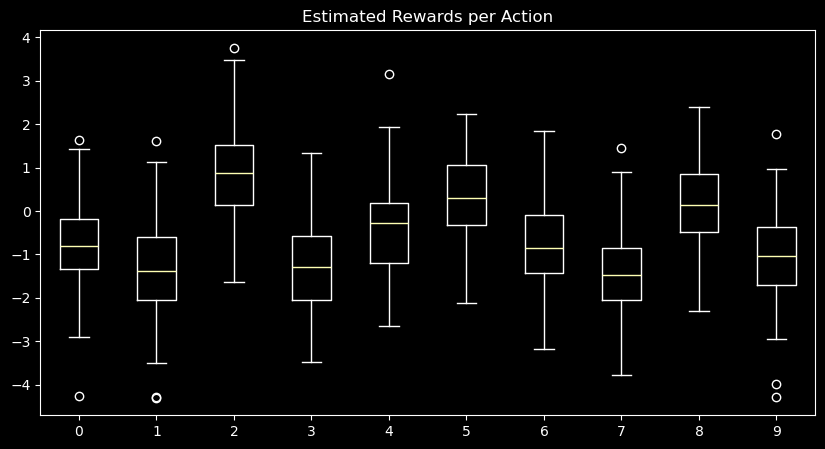

In [5]:
plt.figure(figsize=(10, 5))
plt.boxplot(rewards_per_action, tick_labels=labels)
plt.title('Estimated Rewards per Action')
plt.show()

¿Coincide con el valor verdadero de cada brazo ($q_*(a)$)?

100%|██████████| 2000/2000 [01:10<00:00, 28.47it/s]


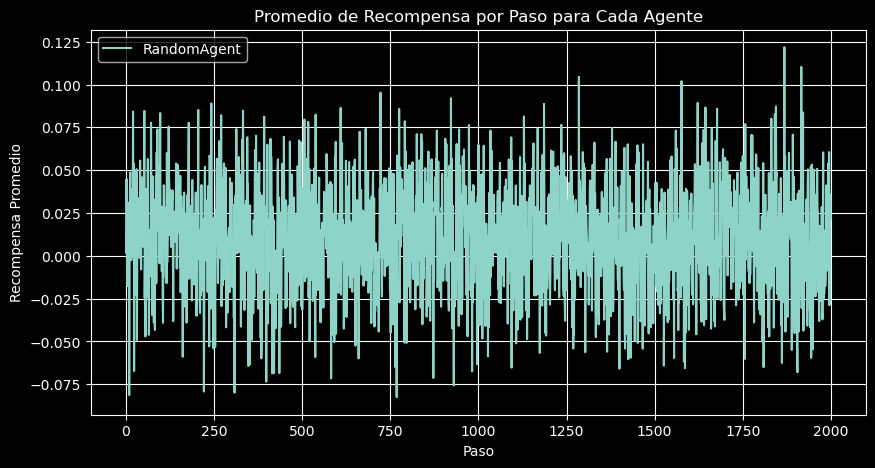

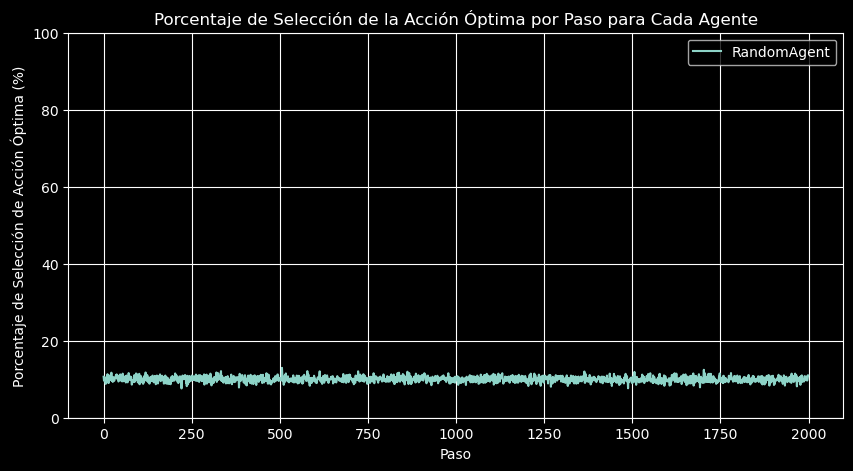

In [6]:
plot_agents_performance([RandomAgent("RandomAgent")], num_steps=2000, num_episodes=2000)

#### Se cumple lo esperado, al ser 10 acciones posibles y tratarse de un agente aleatorio. Debería elegirse la mejor acción aproximadamente el 10% de las veces

### Agente epsilon-greedy

El agentes epsilon-greedy es una estrategia simple que selecciona la mejor acción con probabilidad $1-\varepsilon$ y una acción aleatoria con probabilidad $\varepsilon$.

**Initialize, for** $a = 1$ to $k$:

$$
Q(a) \gets 0
$$

$$
N(a) \gets 0
$$

**Loop forever:**

$$
A \gets 
\begin{cases} 
\arg\max_a Q(a) & \text{with probability } 1 - \varepsilon \quad \text{(breaking ties randomly)} \\
\text{a random action} & \text{with probability } \varepsilon
\end{cases}
$$

$$
R \gets \text{bandit}(A)
$$

$$
N(A) \gets N(A) + 1
$$

$$
Q(A) \gets Q(A) + \frac{1}{N(A)} \left[ R - Q(A) \right]
$$



In [5]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon):
        super().__init__(name)
        self.epsilon = epsilon

    def reset_internal_state(self):
        n = self.environment.action_space.n.item()
        self.Q = np.zeros(n)
        self.N = np.zeros(n)

    def select_action(self, obs, info):
        if np.random.random() < self.epsilon:
            return self.environment.action_space.sample()
        else:
            return np.argmax(self.Q)
   
    def update_internal_state(self, observation, action, reward, info):
        self.N[action]+=1
        self.Q[action]+=(reward-self.Q[action])/self.N[action]
    
    def get_extra_info(self):
        return {"Q": self.Q.tolist(), "N": self.N.tolist()}


epsilon_greedy_agent = EpsilonGreedyAgent("EpsilonGreedyAgent", epsilon=0.01)

logs, info = epsilon_greedy_agent.play(n_steps = 10000, environment =sample_env)

print(info['N'])
print(info['Q'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[16.0, 16.0, 11.0, 7.0, 10.0, 9882.0, 18.0, 16.0, 14.0, 10.0]
[-0.42435636443224134, -0.8063414799003434, 0.08417860068552824, 0.05811342488826375, -0.25183825794116016, 1.6560832327552837, 0.9232035868286682, -1.1512517502626007, -1.001420494775943, 0.8310057023219032]
Accumulated reward: 16337.03
Mean reward: 1.63


In [8]:
rewards_per_action = list(map(lambda x: np.array(x), logs['actions_rewards'].values())) # lista de recompensas por acción
labels = list(logs['actions_rewards'].keys()) # lista de etiquetas de las acciones

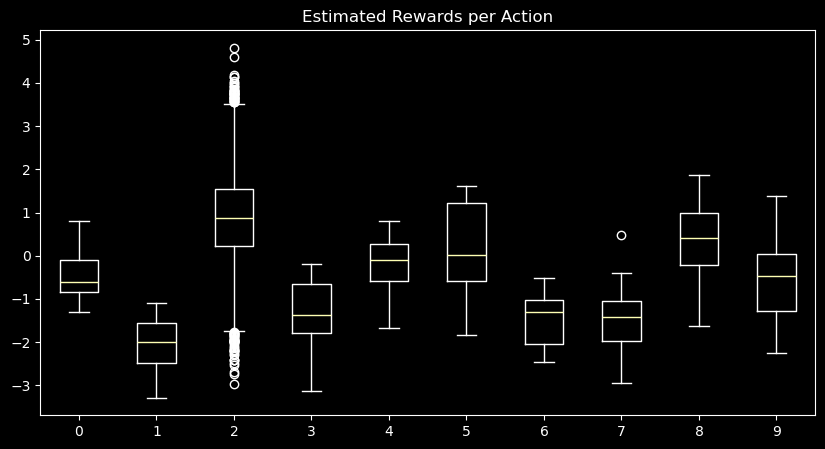

In [9]:
plt.figure(figsize=(10, 5))
plt.boxplot(rewards_per_action, tick_labels=labels)
plt.title('Estimated Rewards per Action')
plt.show()

100%|██████████| 1500/1500 [01:35<00:00, 15.64it/s]


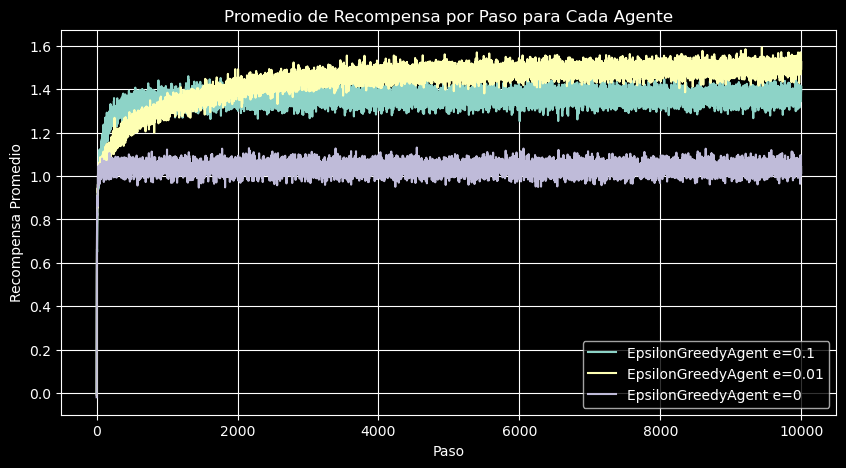

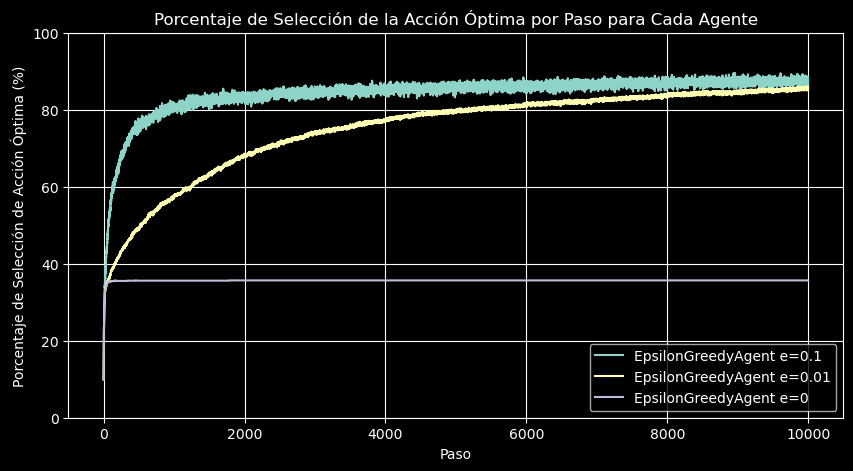

In [10]:
plot_agents_performance([
    EpsilonGreedyAgent("EpsilonGreedyAgent e=0.1", epsilon=0.1),
    EpsilonGreedyAgent("EpsilonGreedyAgent e=0.01", epsilon=0.01),
    EpsilonGreedyAgent("EpsilonGreedyAgent e=0", epsilon=0)
    ], num_steps=10000, num_episodes=1500)

> Sugerencia:
> - Probar con otros valores de $\epsilon$ y comparar el rendimiento de los agentes. ¿Cómo afecta el valor de $\epsilon$ al rendimiento del agente?
> - ¿Qué ocurre si incrementamos la cantidad de pasos de entrenamiento? ¿Cómo afecta esto al rendimiento de los agentes?
>
>```python
>plot_agents_performance([
>    EpsilonGreedyAgent("EpsilonGreedyAgent e=a", a),
>    EpsilonGreedyAgent("EpsilonGreedyAgent e=b", b),
>    ...
>    EpsilonGreedyAgent("EpsilonGreedyAgent e=z", z)
>    ], num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)
>```

100%|██████████| 1500/1500 [04:33<00:00,  5.47it/s]


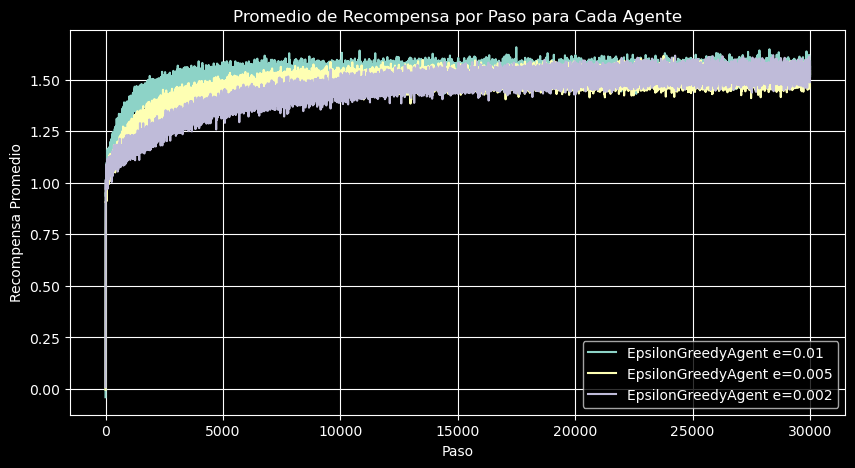

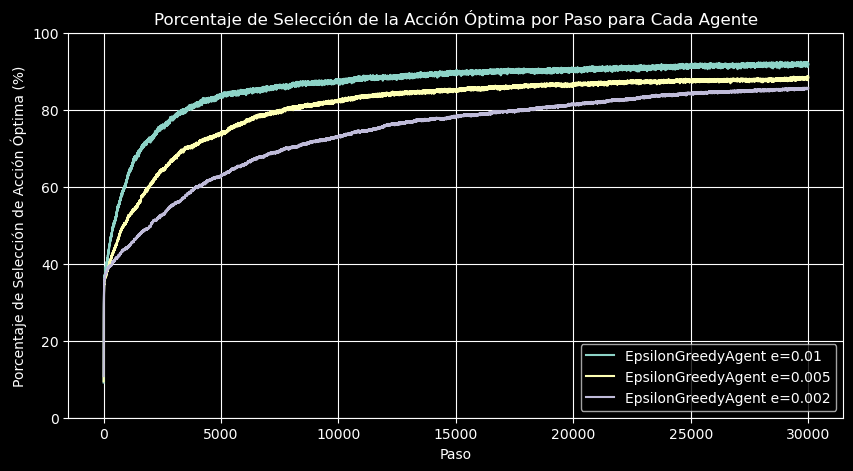

In [11]:
plot_agents_performance([
    EpsilonGreedyAgent("EpsilonGreedyAgent e=0.01", epsilon=0.01),
    EpsilonGreedyAgent("EpsilonGreedyAgent e=0.005", epsilon=0.005),
    EpsilonGreedyAgent("EpsilonGreedyAgent e=0.002", epsilon=0.002)
    ], num_steps=30000, num_episodes=1500)

### Respuesta a la pregunta
Se puede ver que los agentes con valores de epsilons más bajos, a la larga tienden a lograr un mayor porcentaje de selección de la acción óptima pero requieren un mayor número de pasos para alcanzarlo. Es decir, que con el tiempo eligen la mejor acción con mayor frecuencia. Sin embargo, al explorar menos su progreso inicial es más lento. Por esta razón, necesitan más tiempo para superar el rendimiento de los agentes con epsilon más alto, que exploran más al principio. A medida que aumentan los pasos, los agentes con epsilon más bajo terminan superando a los de epsilon mayor, aunque lo hacen más tarde por culpa de su baja exploración.

### Agente epsilon-greedy optimista

El agente epsilon-greedy optimista es una variante del agente epsilon-greedy que inicializa los valores de recompensa estimados ($Q(a)$) con un valor optimista, en lugar de cero. Esto fomenta la exploración de acciones menos conocidas al principio, ya que el agente cree que todas las acciones tienen un valor más alto del que realmente tienen.

Preguntas:
- ¿Qué ocurre si ponemos un valor optimista muy alto?
- ¿Qué ocurre si ponemos un valor optimista muy bajo?

**Initialize, for** $a = 1$ to $k$:

$$
Q(a) \gets q_1
$$

$$
N(a) \gets 0
$$

**Loop forever:**

$$
A \gets 
\begin{cases} 
\arg\max_a Q(a) & \text{with probability } 1 - \varepsilon \quad \text{(breaking ties randomly)} \\
\text{a random action} & \text{with probability } \varepsilon
\end{cases}
$$

$$
R \gets \text{bandit}(A)
$$

$$
N(A) \gets N(A) + 1
$$

$$
Q(A) \gets Q(A) + \alpha (R - Q(A))
$$

> Nota: para esta implementación, usamos $alpha$ en lugar de $\frac{1}{N(A)}$ para actualizar el valor de $Q(A)$. Ver capítulo 2.5 del libro de Sutton y Barto.

In [6]:
class OptimisticEpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon, alpha, q_1):
        super().__init__(name)
        self.epsilon = epsilon
        self.q_1 = q_1
        self.alpha = alpha

    def reset_internal_state(self):
        n = self.environment.action_space.n.item()
        self.Q = np.zeros(n) + self.q_1
        self.N = np.zeros(n)

    def select_action(self, obs, info):
        if np.random.random() < self.epsilon:
            return self.environment.action_space.sample()
        else:
            return np.argmax(self.Q)
   
    def update_internal_state(self, observation, action, reward, info):
        self.N[action]+=1
        self.Q[action]+=self.alpha*(reward-self.Q[action])
    
    def get_extra_info(self):
        return {"Q": self.Q.tolist(), "N": self.N.tolist()}

optimistic_epsilon_greedy_agent = OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent", epsilon = 0.1, alpha=0.1, q_1 = 10)

logs, info = optimistic_epsilon_greedy_agent.play(n_steps = 10000, environment = sample_env)
print(info['Q'])
print(info['N'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[0.04223549553354615, -1.3330345999306354, 0.6039687771135125, 0.2012200254085651, -0.4238202465231835, 1.7139174940494328, 1.0640640986455079, -1.4113089616818293, -1.0893845565120097, 1.1240067534320746]
[119.0, 124.0, 116.0, 107.0, 115.0, 8824.0, 218.0, 109.0, 111.0, 157.0]
Accumulated reward: 14688.72
Mean reward: 1.47


Como me interesa sobre todo el crecimiento inicial. Tomo un numero menor de pasos, que es donde sera visible las estimaciones optimistas de la accion.

100%|██████████| 3000/3000 [00:42<00:00, 71.26it/s]


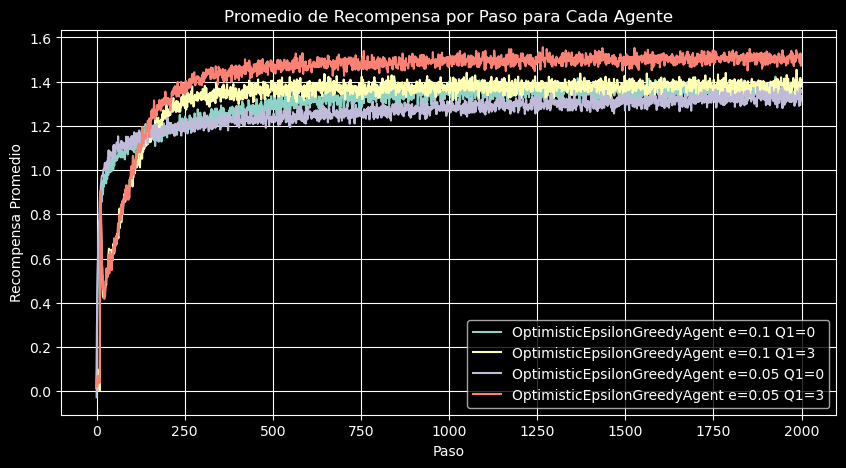

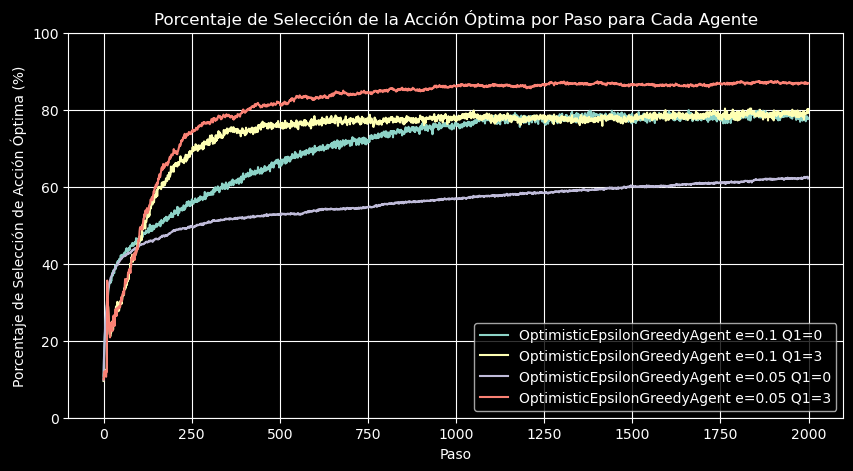

In [13]:
plot_agents_performance([
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.1 Q1=0", epsilon = 0.1, alpha=0.1, q_1 = 0),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.1 Q1=3", epsilon = 0.1, alpha=0.1, q_1 = 3),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.05 Q1=0", epsilon = 0.005, alpha=0.1, q_1 = 0),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.05 Q1=3", epsilon = 0.005, alpha=0.1, q_1 = 3)
    ], num_steps=2000, num_episodes=3000)

Queda en clara evidencia que el uso de estimaciones iniciales optimistas correctas, es de gran utilidad. Es evidente viendo un agente epsilon greedy sin optimismo versus un epsilon greedy con optimismo.

100%|██████████| 4000/4000 [01:24<00:00, 47.50it/s]


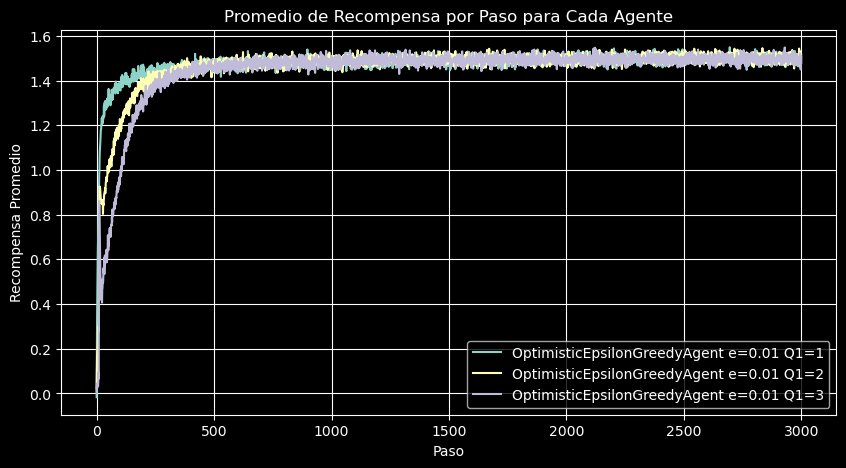

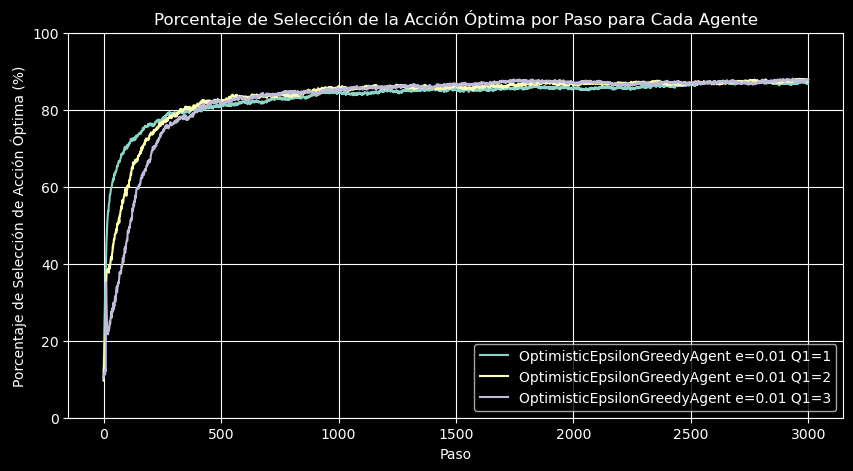

In [14]:
plot_agents_performance([
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.01 Q1=1", epsilon = 0.01, alpha=0.1, q_1 = 1),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.01 Q1=2", epsilon = 0.01, alpha=0.1, q_1 = 2),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.01 Q1=3", epsilon = 0.01, alpha=0.1, q_1 = 3)
    ], num_steps=3000, num_episodes=4000)

Podemos ver como para el caso de epsilon 0.01 nos conviene un q inicial menor. Ya que aprende más rápido, maximizando las recompensas. Procedo a probar con otros valores de epsilon con estimación optimista baja.

100%|██████████| 2000/2000 [02:10<00:00, 15.38it/s]


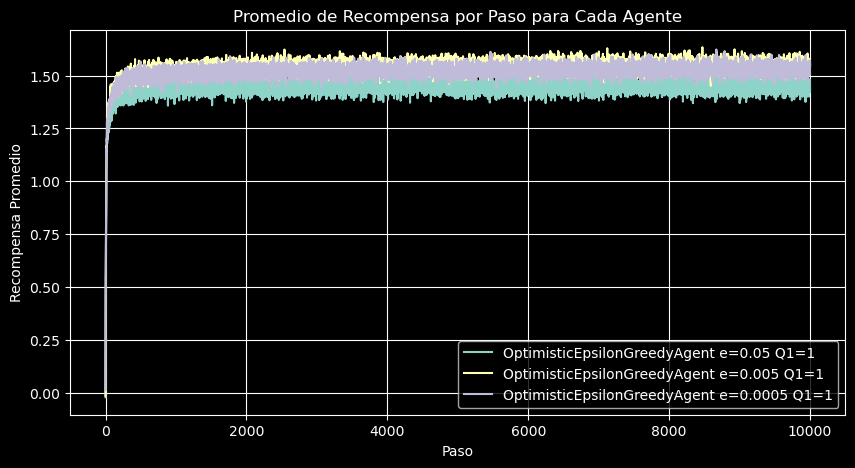

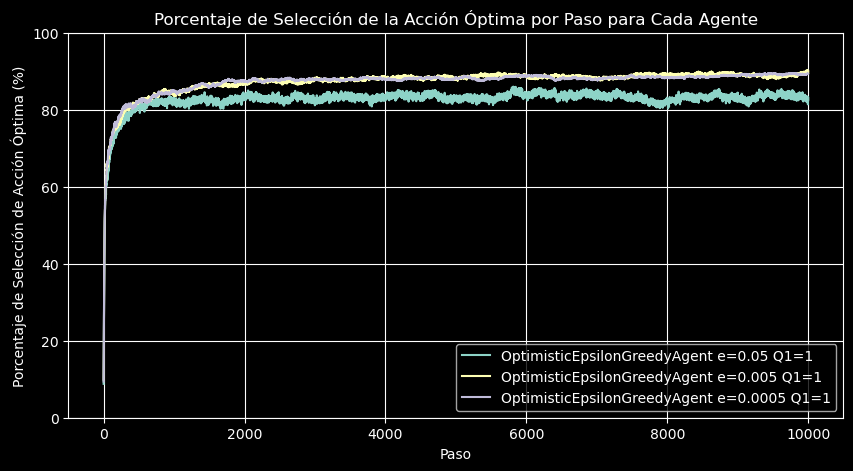

In [15]:
plot_agents_performance([
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.05 Q1=1", epsilon = 0.05, alpha=0.1, q_1 = 1),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.005 Q1=1", epsilon = 0.005, alpha=0.1, q_1 = 1),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.0005 Q1=1", epsilon = 0.0005, alpha=0.1, q_1 = 1)
    ], num_steps=10000, num_episodes=2000)

Priorizamos el 0.005 ya que parece tener el mejor rendimiento. Evaluando que estimación optimista es más conveniente usar.

100%|██████████| 4000/4000 [01:20<00:00, 49.39it/s]


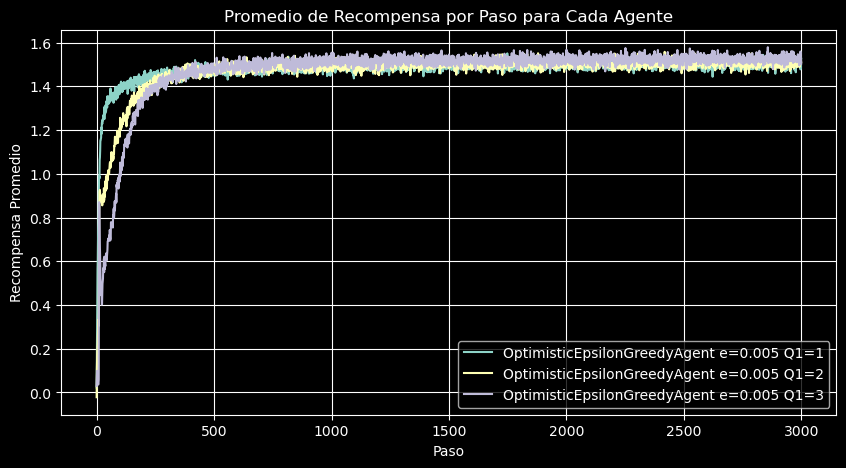

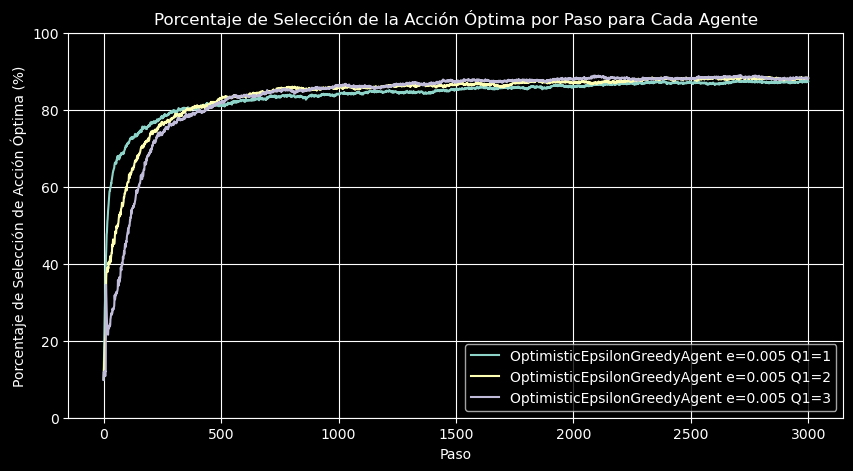

In [16]:
plot_agents_performance([
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.005 Q1=1", epsilon = 0.005, alpha=0.1, q_1 = 1),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.005 Q1=2", epsilon = 0.005, alpha=0.1, q_1 = 2),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.005 Q1=3", epsilon = 0.005, alpha=0.1, q_1 = 3)
    ], num_steps=3000, num_episodes=4000)

100%|██████████| 1000/1000 [00:38<00:00, 26.17it/s]


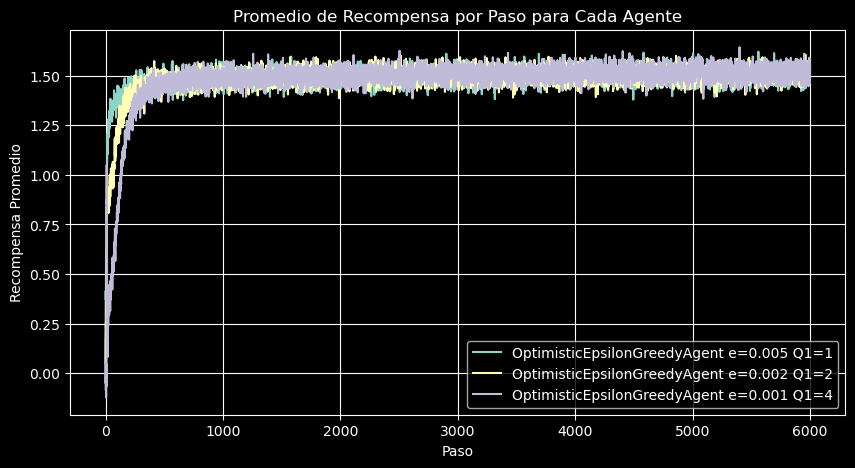

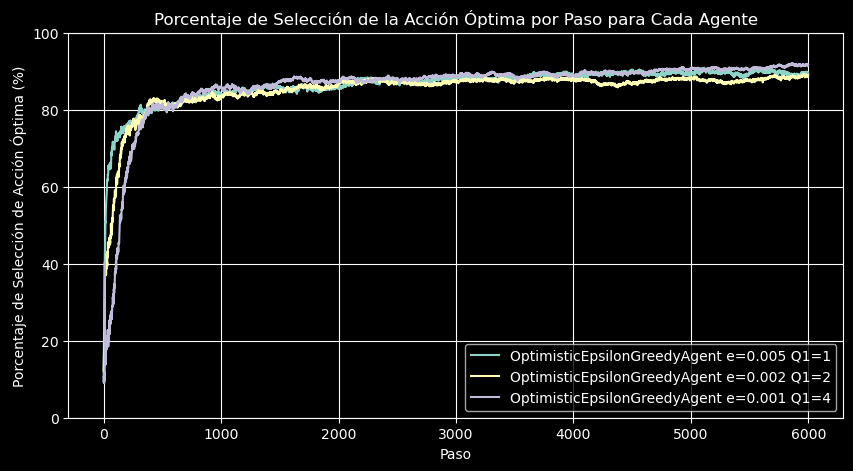

In [17]:
plot_agents_performance([
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.005 Q1=1", epsilon = 0.005, alpha=0.1, q_1 = 1),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.002 Q1=2", epsilon = 0.002, alpha=0.1, q_1 = 2),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0.001 Q1=4", epsilon = 0.001, alpha=0.1, q_1 = 4)
    ], num_steps=6000, num_episodes=1000)

#### Evaluando de manera balanceada
Pruebo realizar un balance entre epsilons menores con mayores estimaciones iniciales. Intentando así, con epsilons menores a 0.005, comenzar con una estimación inicial mayor. Al ver que las gráficas se comportan de manera muy similar. Procuro no extender el número de pasos a realizar para no prolongar demasiado el tiempo de corrida. Priorizo entonces el agente de mayor epsilon. Que se que tendrá un mejor rendimiento para un número de iteraciones menor.

### Agente Upper Confidence Bound (UCB)

El agente UCB es una estrategia de selección de acciones que equilibra de forma inteligente la exploración y la explotación. En lugar de elegir acciones de forma aleatoria con cierta probabilidad (como en epsilon-greedy), el agente UCB asigna a cada acción una "bonificación de exploración" que disminuye conforme la acción es seleccionada más veces. Esta bonificación se combina con la estimación actual del valor $Q(a)$ para formar un criterio de selección.

Para cada acción $a$, se calcula:

$$
UCB(a) = Q(a) + c \sqrt{\frac{\ln t}{N(a)}}
$$

donde:
- $Q(a)$ es la estimación del valor esperado de la acción $a$.
- $N(a)$ es el número de veces que se ha seleccionado la acción $a$.
- $t$ es el número total de pasos (o iteraciones) realizados hasta el momento.
- $c$ es un parámetro que determina el grado de exploración: un valor mayor favorece la exploración de acciones menos probadas.

**Inicialización:**

Para cada acción $a = 1, \dots, k$:

$$
Q(a) \gets 0
$$
$$
N(a) \gets 0
$$
$$
t \gets 0
$$

**Algoritmo:**

**Loop forever:**

   $$
   t \gets t + 1
   $$

   $$
   A \gets \arg\max_a \left\{ Q(a) + c \sqrt{\frac{\ln t}{N(a)}} \right\}
   $$
   $$
   R \gets \text{bandit}(A)
   $$
   $$
   N(A) \gets N(A) + 1
   $$
   $$
   Q(A) \gets Q(A) + \frac{1}{N(A)} \left( R - Q(A) \right)
   $$
   
>Notas: 
>   - Para aquellas acciones que aún no han sido seleccionadas ($N(a) = 0$), se suele asignar un valor infinito al término de exploración para garantizar que cada acción se pruebe al menos una vez.
>   - Se puede usar una tasa de aprendizaje $\alpha$ para actualizar $Q(A)$ en lugar de $\frac{1}{N(A)}$.

### Preguntas:

- **¿Qué sucede si el parámetro $c$ es muy alto?**
- **¿Qué sucede si el parámetro $c$ es muy bajo?**  

In [7]:
class UCBAgent(Agent):
    def __init__(self, name, C):
        super().__init__(name) 
        self.C = C
        self.alfa = 0.1
    def reset_internal_state(self):
        n = self.environment.action_space.n.item()
        self.Q = np.zeros(n)
        self.N = np.zeros(n)
        self.t = 0

    def select_action(self, obs, info):
        self.t+=1
        n = self.environment.action_space.n.item()
        aux = []
        for y in np.arange(n):
            if self.N[y] == 0:
                aux.append(y)
        if len(aux) > 0:
            return np.random.choice(aux)
        else:
            aux = np.zeros(n)
            for x in np.arange(n):
                aux[x] = pow(np.log(self.t)*self.alfa,0.5)
                if self.N[x] == 0:
                    aux[x] = aux[x] * np.inf
                else:
                    aux[x] = aux[x] * self.C
            aux = aux + self.Q       
            return np.argmax(aux)
   
    def update_internal_state(self, observation, action, reward, info):
        self.N[action] += 1
        self.Q[action] += self.alfa*(reward - self.Q[action])
    
    def get_extra_info(self):
        return {"Q": self.Q.tolist(), "N": self.N.tolist()}

UCB_agent = UCBAgent("UCBAgent", C=1)

logs, info = UCB_agent.play(n_steps = 3000, environment =sample_env)
print(info['Q'])
print(info['N'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[0.03893010901890478, -0.078157539461849, 0.029450072825716846, 0.016815489573713743, -0.09899950705438586, 1.8393807647014109, 0.01400870398440094, -0.1842023748227084, -0.040820571006193074, 0.1681261012819805]
[1.0, 1.0, 1.0, 1.0, 1.0, 2991.0, 1.0, 1.0, 1.0, 1.0]
Accumulated reward: 4955.10
Mean reward: 1.65


100%|██████████| 300/300 [01:34<00:00,  3.16it/s]


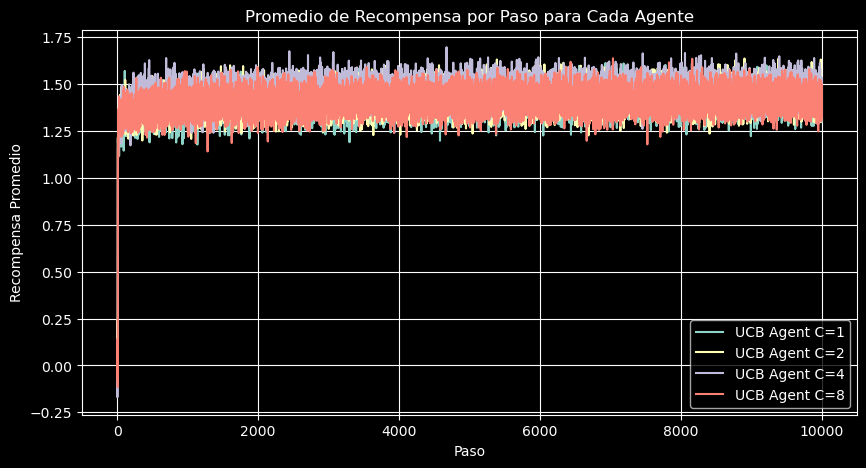

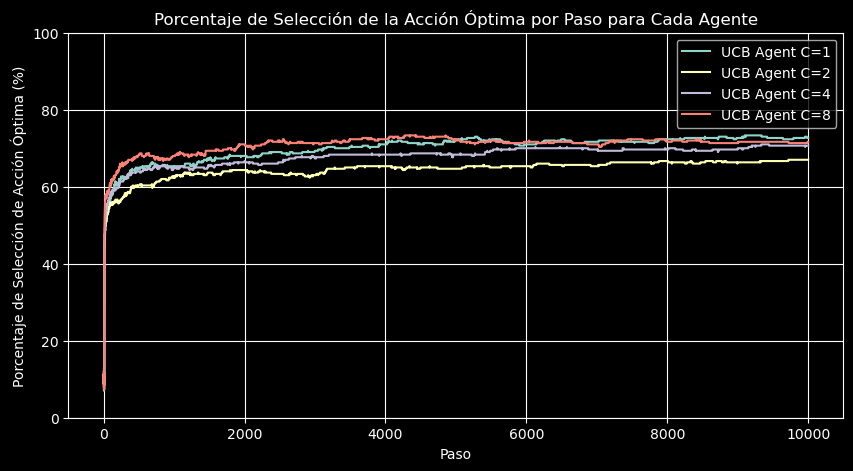

In [19]:
plot_agents_performance([
    UCBAgent("UCB Agent C=1", C=1),
    UCBAgent("UCB Agent C=2", C=2),
    UCBAgent("UCB Agent C=4", C=4),
    UCBAgent("UCB Agent C=8", C=8)
    ], num_steps=10000, num_episodes=300)

### Con respecto a la pregunta de como afecta el parámetro C.

#### Para un C muy alto
Podemos que ver que para un C muy alto el agente explora más. Como consecuencia, demora más en llegar a la mejor acción, porque explora en mayor proporción las otras opción. A su vez, para un número menor de pasos su rendimiento no será tan bueno. Ya que proporción tomar una menor cantidad de veces la acción optima.

#### Para un C muy bajo
El agente explora menos, por lo tanto toma en mayor propoción, la precibida como la mejor acción. Como resultado de explorar poco, puede quedarse fijado en una acción con buena recompensa, por más que esta no es la mejor opción debido a su baja exploración.

100%|██████████| 300/300 [01:33<00:00,  3.19it/s]


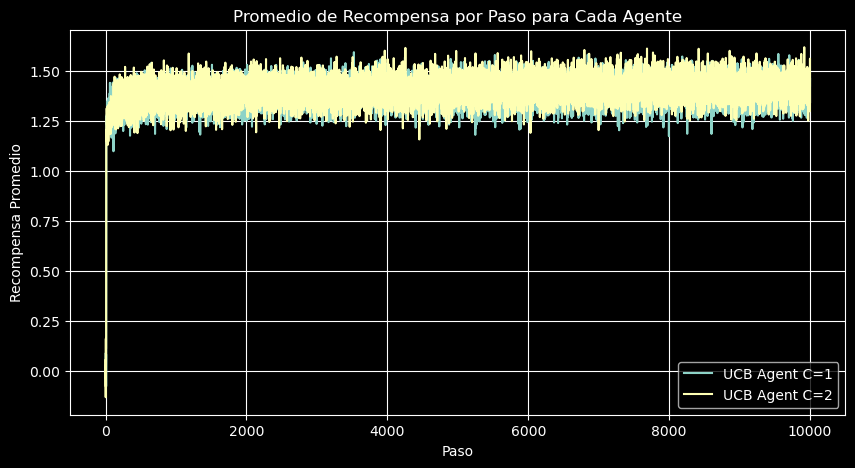

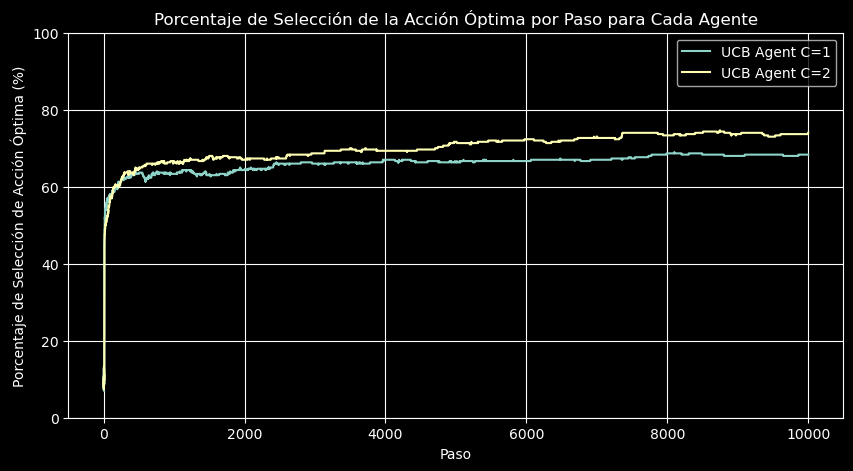

In [20]:
plot_agents_performance([
    UCBAgent("UCB Agent C=1", C=1),
    UCBAgent("UCB Agent C=2", C=2)
    ], num_steps=10000, num_episodes=300)

In [11]:
epsilon_greedy_agent = EpsilonGreedyAgent("EpsilonGreedyAgent", epsilon=0.007)

logs, info = epsilon_greedy_agent.play(n_steps = 10000, environment =sample_env)

print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

Accumulated reward: 16395.82
Mean reward: 1.64


In [12]:
optimistic_epsilon_greedy_agent = OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent", epsilon = 0.005, alpha=0.1, q_1 = 1)

logs, info = optimistic_epsilon_greedy_agent.play(n_steps = 10000, environment = sample_env)

print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

Accumulated reward: 16523.54
Mean reward: 1.65


In [13]:
UCB_agent = UCBAgent("UCBAgent", C=2)

logs, info = UCB_agent.play(n_steps = 10000, environment =sample_env)

print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

Accumulated reward: 16684.81
Mean reward: 1.67


100%|██████████| 2000/2000 [10:28<00:00,  3.18it/s]


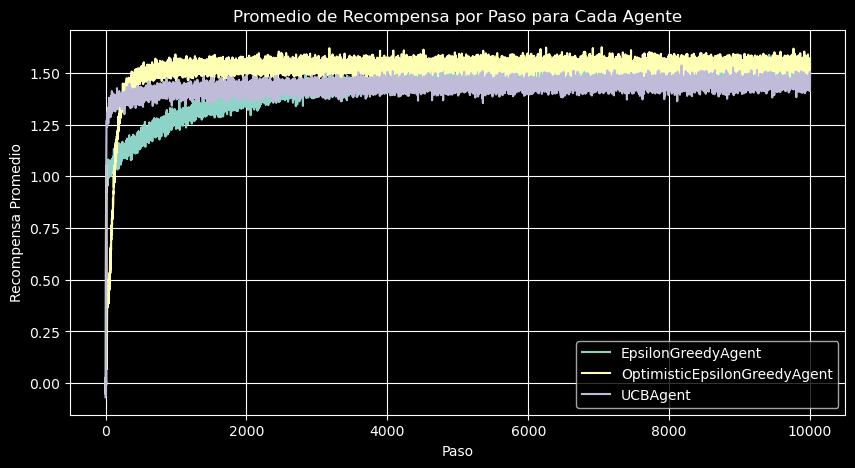

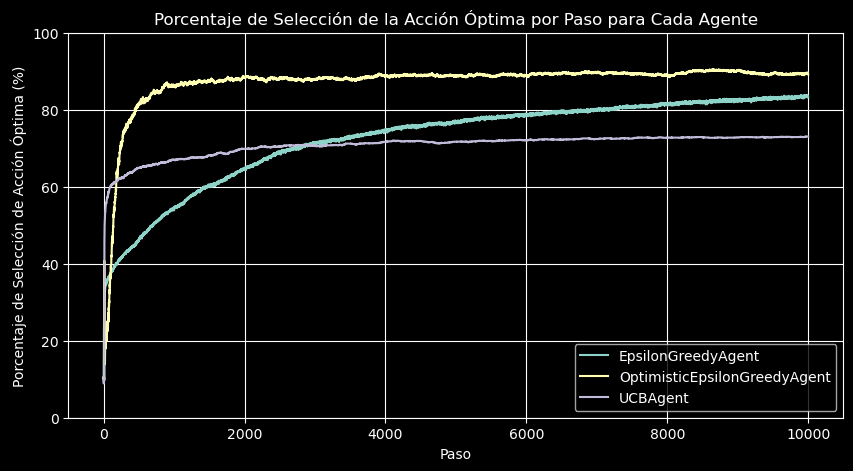

In [14]:
plot_agents_performance([
    EpsilonGreedyAgent("EpsilonGreedyAgent", epsilon=0.007),
    OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent", epsilon = 0.001, alpha=0.1, q_1 = 4),
    UCBAgent("UCBAgent", C=2)
    ], num_steps=10000, num_episodes=2000)

### Picos en las gráficas

Se puede ver un pico hacía abajo con claridad en la gráfica de optimistic epsilon greedy de más arriba. Esto se debe porque al comenzar con estimaciones de valor muy altas (como marca la pauta del agente), las primeras recompensas reales que se obtienen del ambiente suelen ser mucho menores. Esta diferencia provoca una corrección brusca en la estimación del valor de esa acción, lo que genera la caída abrupta que se refleja en la gráfica.

## Tareas

1. Implementar los agentes mencionados.
2. Comentar los resultados obtenidos en las gráficas.
3. Seleccionar de cada agente el/los mejores hiperparámetros.
4. Tomar el mejor candidato de cada agente y compararlos en un mismo gráfico.
5. Explique porque en algunos agentes sus graficas tienen picos (epsilon-greedy optimista y UCB).
6. [Extra] Implementar un agente [epsilon-greedy con decay](https://arxiv.org/pdf/1910.13701).